In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

In [11]:
import joblib
from joblib import Parallel,delayed

In [2]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300641', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [3]:
from statsmodels.stats.weightstats import DescrStatsW
def getq(x,a,q):
    wq = DescrStatsW(data=x.values.ravel(), weights=a.values.ravel())
    qq=wq.quantile(probs=q, return_pandas=False)
    return qq[0]

In [4]:
def calc_metric(ds,v):
    #establishing the averaging period
    # we want 5 thirty-year (360 month) chunks
    g=np.repeat(range(5),360)  #focus period
    g=np.concatenate([np.zeros(len(ds.time)-len(g))-1,g]) #front padding with a group (-1) I will ignore
    g=xr.DataArray(g,dims='time',name='metric')  #converting to DataArray

    #calculate mean and variance
    dpm=ds['time.daysinmonth']
    x=1/dpm.groupby(g).sum()*(dpm*ds[v]).groupby(g).sum()
    y=ds[v].groupby(g).var()

    #concatenate and label
    m=xr.concat([x.sel(metric=range(5)),y.sel(metric=range(5))],dim='metric')
    m['metric']=np.repeat([v+'mean',v+'var'],5)

    return m.compute()

In [96]:
def amean(da,cf=1/365):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf*(m*da).groupby('time.year').sum().compute()
    return xa

In [5]:
gvs=['TSA', 'RAIN', 'TOTECOSYSC', 'HR', 'SNOW', 'TOTECOSYSN', 'Q2M',
     'TOTSOILICE', 'NBP', 'FSDS', 'TOTSOILLIQ', 'QRUNOFF', 'FSNO',
     'FSH', 'EFLX_LH_TOT']
pftvs=['GPP','AR','TLAI','FCTR']

### prepping metrics

In [10]:
#reading in some h0 data
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))
tmp0=xr.open_dataset(files[0])

In [563]:
#reading in some h0 data
def preprocess(ds):
    return ds[gvs]

ds0=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                     preprocess=preprocess)
yr0=ds0['time.year'][0].values
ds0['time']=xr.cftime_range(str(yr0),periods=len(ds0.time),freq='MS',calendar='noleap')


In [601]:
ms=[]
for v in gvs:
    print(v)
    ms.append(calc_metric(ds0,v))

TSA
RAIN
TOTECOSYSC
HR
SNOW
TOTECOSYSN
Q2M
TOTSOILICE
NBP
FSDS
TOTSOILLIQ
QRUNOFF
FSNO
FSH
EFLX_LH_TOT


In [603]:
metrics=xr.concat(ms,dim='metric')

### h1 metrics

In [16]:
#reading in some h1 data and prep landarea array
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h1*'))
tmp=xr.open_dataset(files[0])
def preprocess(ds):
    return ds[[*pftvs,'pfts1d_wtgcell']]

ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                     preprocess=preprocess)
yr0=ds['time.year'][0].values
ds['time']=xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS',calendar='noleap')

In [33]:
#reading in some h0 data
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))
tmp0=xr.open_dataset(files[0])
#create landarea array
nlon=len(normal.lon)
nlat=len(normal.lat)
ix=((tmp.pfts1d_jxy-1)*nlon+tmp.pfts1d_ixy-1).astype(int)
a=tmp0.area*tmp0.landfrac*(tmp0.lat>-60)
la=(ds.pfts1d_wtgcell*a.fillna(0).stack({'gc':['lat','lon']}).isel(gc=ix)).compute()


In [80]:
dsout=xr.Dataset()
dsout['lapft']=xr.DataArray(la.values,coords=[la.time,la.pft])
dsout['lat']=xr.DataArray(la.lat.values,dims='pft')
dsout['lon']=xr.DataArray(la.lon.values,dims='pft')
dsout.to_netcdf('/glade/work/djk2120/ppe_savs/pbmean/lapft_noantarc.nc')

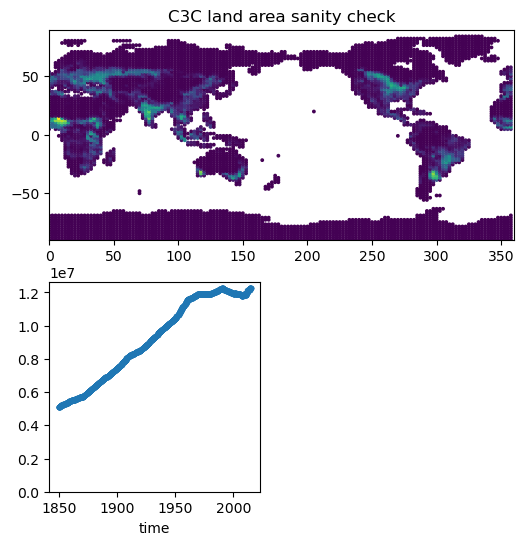

In [44]:
ixp=tmp.pfts1d_itype_veg==15
plt.figure(figsize=[6,6])
plt.subplot(211)
plt.scatter(tmp.pfts1d_lon[ixp],tmp.pfts1d_lat[ixp],
            c=la.isel(pft=ixp,time=-1),s=3)
plt.xlim([0,360])
plt.ylim([-90,90])
plt.title('C3C land area sanity check')

plt.subplot(223)
la.isel(pft=ixp).sum(dim='pft').plot.line('.')
plt.ylim(bottom=0);

In [48]:
m=[calc_metric(ds,v) for v in pftvs]
m.append(1000*tmp.pfts1d_itype_veg.expand_dims({'metric':['PFT']})) #this will force algorithm to match PFT

In [55]:
metrics=xr.concat(m,dim='metric')
metrics.to_netcdf('/glade/work/djk2120/ppe_savs/pbmean/metrics_h1.nc')

### start from existing metrics

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
#h0
metrics=xr.open_dataset('/glade/work/djk2120/ppe_savs/pbmean/metrics_h0.nc').metrics

#h0 landarea array
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))
tmp0=xr.open_dataset(files[0])
a=(tmp0.landfrac*tmp0.area*(tmp0.lat>-60)).fillna(0)  #mask antarctica

#normalize based on area-weighted 5th/95th percentiles
q1=xr.DataArray([getq(m,a,0.05) for m in metrics],dims='metric')
q2=xr.DataArray([getq(m,a,0.95) for m in metrics],dims='metric')
normal=(metrics-q1)/(q2-q1)

#tile into pft shaped array
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h1*'))
tmp=xr.open_dataset(files[0])
nlon=len(normal.lon)
nlat=len(normal.lat)
ix=((tmp.pfts1d_jxy-1)*nlon+tmp.pfts1d_ixy-1).astype(int)
normal=normal.stack({'gc':['lat','lon']}).isel(gc=ix)
metrics=metrics.stack({'gc':['lat','lon']}).isel(gc=ix)

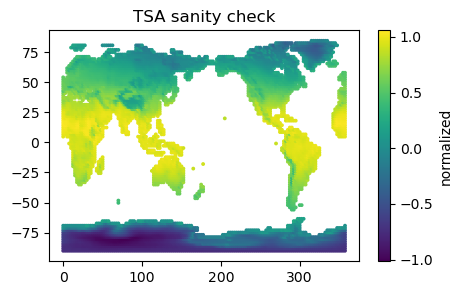

In [8]:
ixp=tmp.pfts1d_itype_veg==4
plt.figure(figsize=[5,3])
plt.scatter(tmp.pfts1d_lon[ixp],tmp.pfts1d_lat[ixp],c=normal.isel(metric=4,pft=ixp),s=3)
plt.colorbar(label='normalized')
plt.title('TSA sanity check');

In [9]:
#h1
f='/glade/work/djk2120/ppe_savs/pbmean/metrics_h1.nc'
m0=xr.open_dataset(f).metrics
m=m0.isel(metric=range(len(m0.metric)-1))

In [ ]:
ds=xr.open_dataset('/glade/work/djk2120/ppe_savs/pbmean/lapft_noantarc.nc')
a=calc_metric(ds,'lapft').isel(metric=range(5))
a=xr.concat([a for i in range(8)],dim='metric')

In [34]:
#normalize based on area-weighted 5th/95th percentiles
q1=xr.DataArray([getq(m,a,0.05) for m,a in zip(m,a)],dims='metric')
q2=xr.DataArray([getq(m,a,0.95) for m,a in zip(m,a)],dims='metric')
n =(m-q1)/(q2-q1)

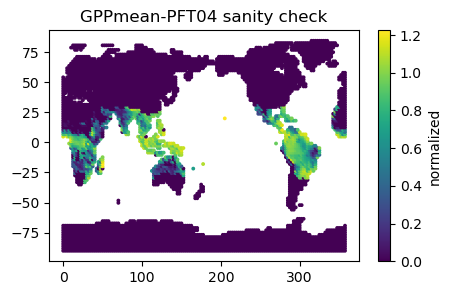

In [53]:
p=4
mm=1
ixp=tmp.pfts1d_itype_veg==p
plt.figure(figsize=[5,3])
plt.scatter(tmp.pfts1d_lon[ixp],
            tmp.pfts1d_lat[ixp],
            c=n.isel(metric=mm,pft=ixp),s=3)
plt.colorbar(label='normalized')
plt.title(str(m.metric[mm].values)+'-PFT'+str(p).zfill(2)+' sanity check');

In [63]:
nmetrics=xr.concat([normal,n,m0.sel(metric='PFT')],dim='metric').fillna(0)

1.0


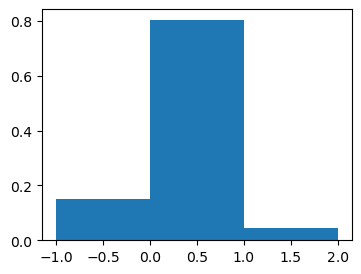

In [73]:
plt.figure(figsize=[4,3])
c,bins,f=plt.hist(nmetrics.values.ravel(),-1+np.arange(4),density=True);
print(c.sum()) #should be very close to 1 if normalized properly

### calculating distance to centroids

In [74]:
# read in random sparsegrid file
f = '/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
sg = xr.open_dataset(f)

In [75]:
fgmap=xr.open_dataset('fgmap.nc').fgmap
vs=['pfts1d_lat','pfts1d_lon','pfts1d_itype_veg']

In [76]:
c=nmetrics.isel(pft=fgmap)
c['centroids']=c.pft
centroids=c.swap_dims({'pft':'c'})

In [83]:
#spot check
#prints lat/lon/pft for fullgrid and corresponding sg cell
p=43005
c=((nmetrics.sel(pft=p)-centroids)**2).sum(dim='metric').argmin()
print([np.round(tmp[v].sel(pft=p).values,1) for v in vs])
print([np.round(sg[v].sel(pft=c).values,1) for v in vs])

[-10.4, 282.5, 4.0]
[-14.2, 12.5, 4.0]


In [84]:
#spot check
p=47232
c=((nmetrics.sel(pft=p)-centroids)**2).sum(dim='metric').argmin()
print([np.round(tmp[v].sel(pft=p).values,1) for v in vs])
print([np.round(sg[v].sel(pft=c).values,1) for v in vs])

[-2.8, 315.0, 14.0]
[-8.5, 295.0, 14.0]


In [85]:
import joblib
from joblib import Parallel,delayed

In [86]:
def findc(x,centroids):
    c=((x-centroids)**2).sum(dim='metric').argmin(dim='c')
    return c

In [100]:
#split into manageable chunks
npft=len(nmetrics.pft)
xs=[nmetrics.isel(pft=range(i*100,min(npft,(i+1)*100))).compute() for i in range(1+int(npft/100))]

In [102]:
#classify in parallel
with joblib.parallel_config(backend="dask"):
    results=Parallel(verbose=1)(delayed(findc)(x,centroids) for x in xs)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 740 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 1189 out of 1189 | elapsed:  1.5min finished


In [103]:
c=xr.concat(results,dim='pft').compute()

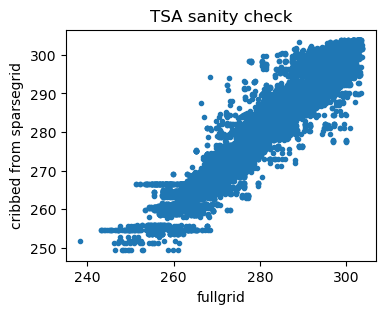

In [106]:
plt.figure(figsize=[4,3])
plt.plot(metrics.isel(metric=4).where(tmp.pfts1d_itype_veg>0),sg.TSA.mean(dim='time').isel(pft=c),'.')
plt.xlabel('fullgrid')
plt.ylabel('cribbed from sparsegrid')
plt.title('TSA sanity check');

In [119]:
x=metrics.isel(metric=4).values
y=sg.TSA.mean(dim='time').isel(pft=c).values
ix=(x>0)&(~np.isnan(x))&(y>0)&(~np.isnan(y))&(tmp.pfts1d_itype_veg>0)
r2=np.corrcoef(x[ix],y[ix])[0,1]**2
print('R2=',np.round(r2,2))

R2= 0.95


In [134]:
ds=xr.Dataset()
ds['sgpft_cribsheet']=c
ds['not_antarctica']=tmp.pfts1d_lat>-60
ds['vegetated']=tmp.pfts1d_itype_veg>0
ds['lat']=tmp.pfts1d_lat
ds['lon']=tmp.pfts1d_lon
ds['pfts1d_itype_veg']=tmp.pfts1d_itype_veg

In [135]:
ds.to_netcdf('/glade/work/djk2120/ppe_savs/pbmean/sgpft_cribsheet.nc')

### classify fullgrid pft by biome

In [190]:
def byhand(t,p):
    t1 = -5  #    tundra-boreal
    t2 =  3  #    boreal-temperate
    t3 = 20  # temperate-tropical

    tvals = [-np.inf,t1,t2,t3,np.inf]
    bvals = [9,8,4,1]


    for i in range(4):
        if (t>tvals[i])&(t<=tvals[i+1]):
            b = bvals[i]

    td = 15; pd=60; bd=3  #desert
    if (t>td)&(p<pd):
        b = bd

    return b

In [191]:
import joblib
from joblib import Parallel,delayed
import geopandas as gpd
from shapely.geometry import *




In [181]:
#reading in some h0 data
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))[-360:]
tmp0=xr.open_dataset(files[0])
def preprocess(ds):
    return ds[['TBOT','RAIN','SNOW']]
ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                     preprocess=preprocess)
yr0=ds['time.year'][0].values
ds['time']=xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS',calendar='noleap')
ds0=amean(ds).mean(dim='year')
ds0['PREC']=ds0.RAIN+ds0.SNOW

In [182]:
#tile into pft shaped array
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h1*'))
tmp=xr.open_dataset(files[0])
nlon=len(ds.lon)
nlat=len(ds.lat)
ix=((tmp.pfts1d_jxy-1)*nlon+tmp.pfts1d_ixy-1).astype(int)
climo=ds0.stack({'gc':['lat','lon']}).isel(gc=ix)

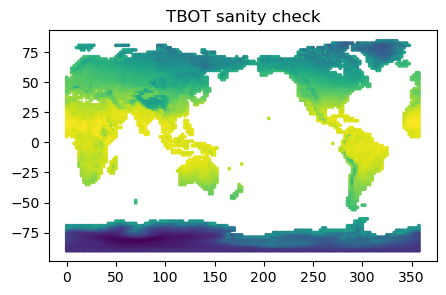

In [183]:
ixp=tmp.pfts1d_itype_veg==4
v='TBOT'
plt.figure(figsize=[5,3])
plt.scatter(tmp.pfts1d_lon[ixp],
            tmp.pfts1d_lat[ixp],
            c=climo[v].isel(pft=ixp),s=3)
plt.title(v+' sanity check');

In [184]:
#add GPP
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h1*'))[-360:]
tmp=xr.open_dataset(files[0])
def preprocess(ds):
    return ds[['GPP']]
ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                     preprocess=preprocess)
yr0=ds['time.year'][0].values
ds['time']=xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS',calendar='noleap')
climo['GPP']=amean(ds.GPP).mean(dim='year')

In [204]:
fp = './whit/Whittaker_biomes.shp'
whit = gpd.read_file(fp)
newb = np.array([9,8,7,6,5,4,1,2,3])
whit.biome_id=newb #more logical order
def get_bclass(climo,n,whit):
    t=climo.TBOT-273.15   #degC
    pr=24*60*60*365/10*climo.PREC  #cm/yr
    npft=len(climo.pft)
    pp=[i for i in range(n*1000,min(npft,(n+1)*1000))]
    bclass=np.zeros(len(pp))+np.nan
    for i in range(len(pp)):
        p=pp[i]
        if (t[p]<0)&(climo.GPP[p]==0):
            bclass[i]=0  #ice
        else:
            ptf = gpd.GeoDataFrame({'geometry':[Point(t[p],pr[p])]})
            x=gpd.overlay(ptf, whit, how='intersection')
            if len(x)>0:
                bclass[i] = x.biome_id.values[0]
            else:
                bclass[i] = byhand(t[p],pr[p])
    return bclass

In [205]:
with joblib.parallel_config(backend="dask"):
    results=Parallel(verbose=1)(delayed(get_bclass)(climo,i,whit) for i in range(119))

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:   37.2s finished


In [206]:
bclass=xr.DataArray(np.concatenate(results),dims='pft')
xr.Dataset({'bclass_pft':bclass}).to_netcdf('/glade/work/djk2120/ppe_savs/pbmean/bclass_pft.nc')

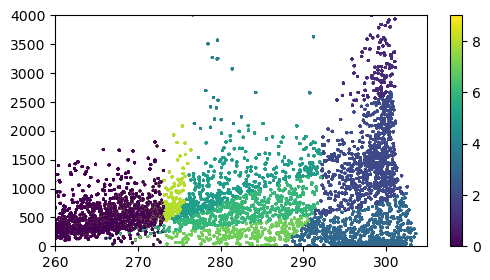

In [213]:
plt.figure(figsize=[6,3])
plt.scatter(climo.TBOT,24*60*60*365*climo.PREC,c=bclass,s=1)
plt.ylim([0,4000])
plt.xlim([260,305])
plt.colorbar();

### calculate represented area for each pxb

In [6]:
# read in various helpers
f = '/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
sg = xr.open_dataset(f)
sgpft=xr.DataArray(sg.pft,dims='sg')
f='/glade/work/djk2120/ppe_savs/pbmean/sgpft_cribsheet.nc'
xx=xr.open_dataset(f)
crib=xx.sgpft_cribsheet
pft=xx.pfts1d_itype_veg
f='/glade/work/djk2120/ppe_savs/pbmean/lapft_noantarc.nc'
yy=xr.open_dataset(f)
la=yy.lapft
f='/glade/work/djk2120/ppe_savs/pbmean/bclass_pft.nc'
bclass=xr.open_dataset(f).bclass_pft

In [17]:
def get_lapb(la,sgp,pxb):
    return (la*(crib==sgp)).groupby(pxb).sum().compute()

In [36]:
#I'm splitting the sparsegrid into three chunks and landarea by year
#in order to manage memory to run get_lapb in parallel
nx=int(len(sg.pft)/3)
if nx!=len(sg.pft)/3:
    raise RuntimeError("sg not divisible by 3")
sgps=[sgpft.isel(sg=range(i*nx,(i+1)*nx)) for i in range(3)]
jans=range(0,1980,12)
las=[la.isel(time=t).compute() for t in jans]
yrs=[la['time.year'][t] for t in jans]
#pxb group puts pft in the first one or two digits
#          and  biome in the last digit
pxb=(10*pft+bclass).astype(int)
pxb.name='pxb'

In [ ]:
#calculate represented area
rr=[]
for sgp in sgps:
    with joblib.parallel_config(backend="dask"):
        results=Parallel(verbose=1)(delayed(get_lapb)(la,sgp,pxb) for la in las)
    rr.append(xr.concat(results,dim='year'))

#concatenate and label
lapb=xr.concat(rr,dim='sg')
lapb['year']=yrs
lapb['pft']=xr.DataArray(lapb.sg,dims='sg')
lapb=lapb.swap_dims({'sg':'pft'})

In [52]:
xr.Dataset({'lapxb':lapb}).to_netcdf('/glade/work/djk2120/ppe_savs/pbmean/sg_lapxb.nc')

### examine results

In [55]:
lapxb=xr.open_dataset('/glade/work/djk2120/ppe_savs/pbmean/sg_lapxb.nc').lapxb

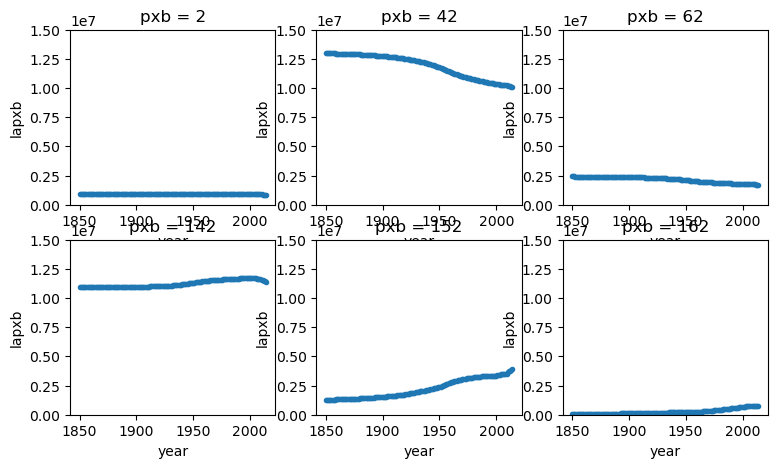

In [88]:
plt.figure(figsize=[9,5])
for i,x in enumerate([2,42,62,142,152,162]):
    plt.subplot(2,3,i+1)
    lapxb.sel(pxb=x).sum(dim='pft').plot.line('.')
    plt.ylim([0,1.5e7])

In [90]:
#reading in TLAI data from fullgrid
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h1*'))[-360:]
tmp=xr.open_dataset(files[0])
def preprocess(ds):
    return ds[['TLAI']]

ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                     preprocess=preprocess)
yr0=ds['time.year'][0].values
ds['time']=xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS',calendar='noleap')

In [98]:
#subset sparsegrid points
fgmap=xr.open_dataset('fgmap.nc').fgmap
lai=amean(ds.TLAI).isel(pft=fgmap)

In [107]:
laipxb=1/lapxb.sum(dim='pft')*(lapxb*lai).sum(dim='pft')

In [115]:
dsout=xr.Dataset()
dsout['lai_pxb_sg_newmap']=laipxb
dsout['area']=lapxb.sum(dim='pft')
f='/glade/work/djk2120/ppe_savs/pbmean/lai_pxb_sg_newmap.nc'
dsout.to_netcdf(f)

In [148]:
files

['/glade/work/djk2120/ppe_savs/pbmean/lai_pxb_fg.nc',
 '/glade/work/djk2120/ppe_savs/pbmean/lai_pxb_sg.nc',
 '/glade/work/djk2120/ppe_savs/pbmean/lai_pxb_sg_newmap.nc']

In [117]:
dvs=['lai_pxb_fg','lai_pxb_sg','lai_pxb_sg_newmap']
d='/glade/work/djk2120/ppe_savs/pbmean/'
files=[d+v+'.nc' for v in dvs]
lais={v:xr.open_dataset(f)[v] for f,v in zip(files,dvs)}

In [121]:
area=xr.open_dataset(files[0]).area

In [143]:
bigs=area.mean(dim='year').argsort()[-15:]
pbs=np.flipud([laipxb.pxb[big].values for big in bigs])
pbs=pbs[pbs>9]  #exclude PFT0 - not_vegetated

In [135]:
p=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/LHC0000.nc')
pftnames=[str(p)[2:-1].strip() for p in p.pftname[:17].values]
whit=xr.open_dataset('whit/whitkey.nc')

In [163]:
ix=(area.mean(dim='year')>250000)&(area.pxb>9)
pxbs=area.pxb[ix][np.flipud(area.mean(dim='year').isel(pxb=ix).argsort())]


In [167]:
import warnings
warnings.filterwarnings('ignore')

In [219]:
da1=lais['lai_pxb_fg']
da2=lais['lai_pxb_sg']
r2old=np.array([np.corrcoef(da1.sel(pxb=pxb),da2.sel(pxb=pxb))[0,1]**2 for pxb in pxbs])
rmseold=np.array([np.sqrt(np.mean((da1.sel(pxb=pxb)-da2.sel(pxb=pxb))**2)) for pxb in pxbs])
da1=lais['lai_pxb_fg']
da2=lais['lai_pxb_sg_newmap']
r2new=np.array([np.corrcoef(da1.sel(pxb=pxb),da2.sel(pxb=pxb))[0,1]**2 for pxb in pxbs])
rmsenew=np.array([np.sqrt(np.mean((da1.sel(pxb=pxb)-da2.sel(pxb=pxb))**2)) for pxb in pxbs])

In [199]:
for i,b in enumerate(whit.biome_name.values):
    print(i,b)

0 Ice sheet
1 Tropical rain forest
2 Tropical seasonal forest/savanna
3 Subtropical desert
4 Temperate rain forest
5 Temperate seasonal forest
6 Woodland/shrubland
7 Temperate grassland/desert
8 Boreal forest
9 Tundra


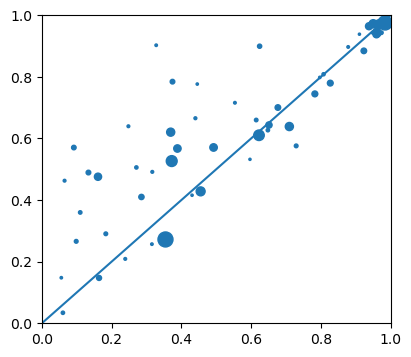

In [220]:
plt.figure(figsize=[4.5,4])
plt.scatter(r2old,r2new,s=area.sel(pxb=pxbs).mean(dim='year')/1e5)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1]);

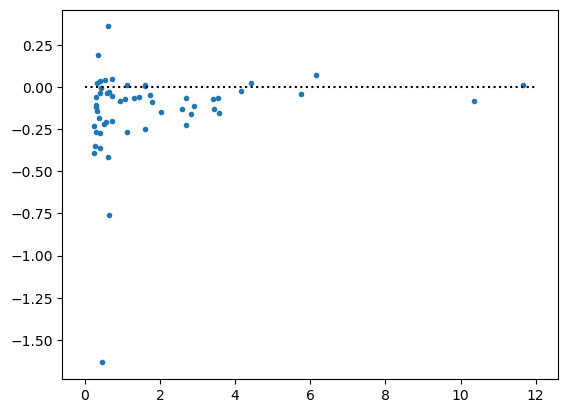

In [223]:
plt.plot(area.sel(pxb=pxbs).mean(dim='year')/1e6,rmsenew-rmseold,'.')
plt.plot([0,12],[0,0],'k:');

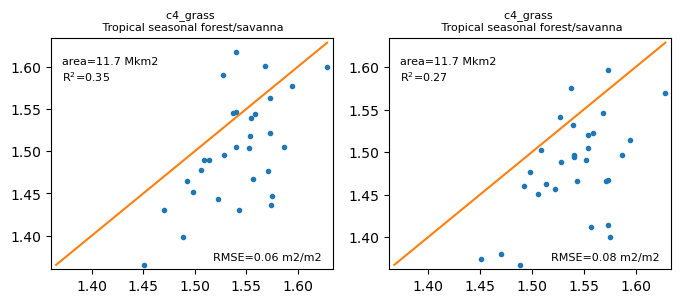

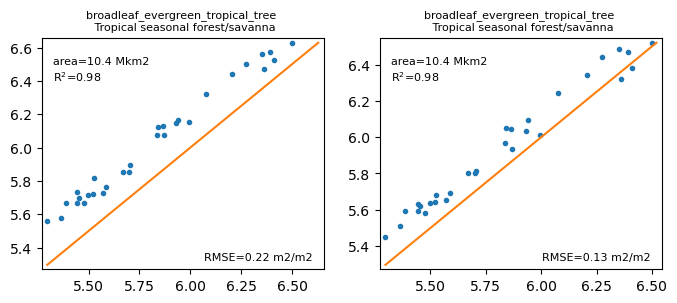

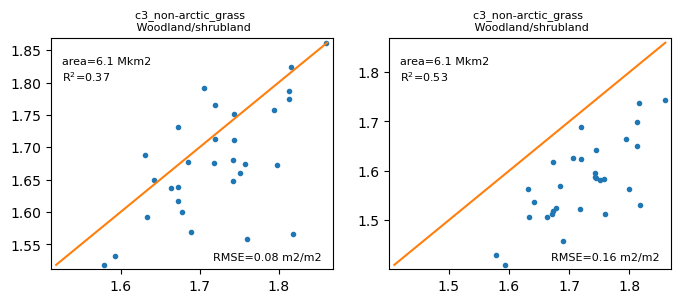

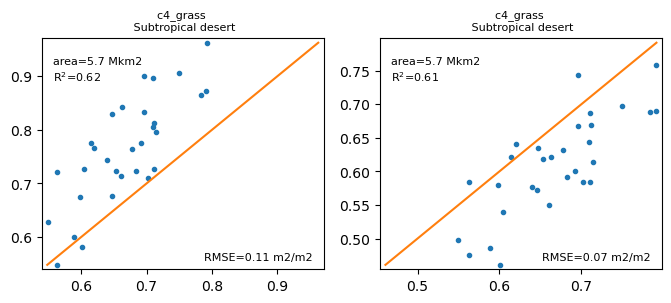

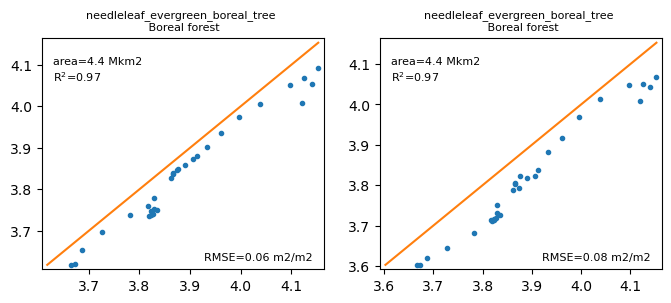

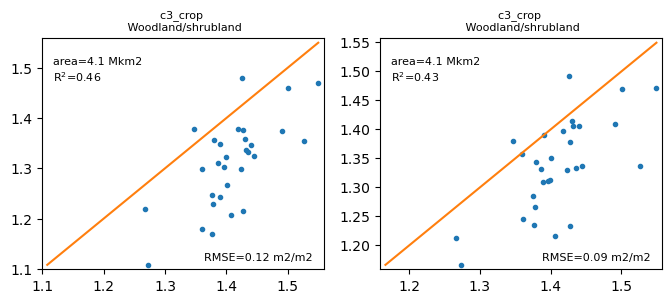

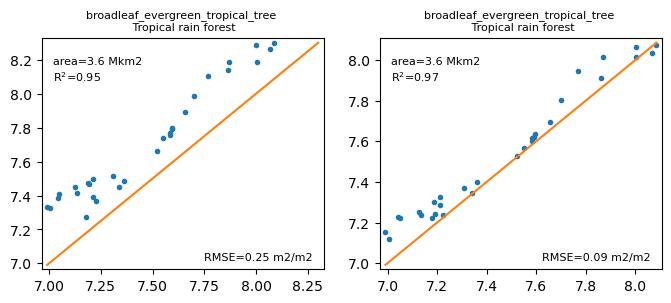

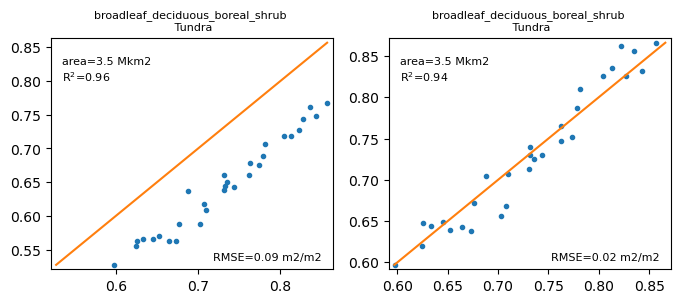

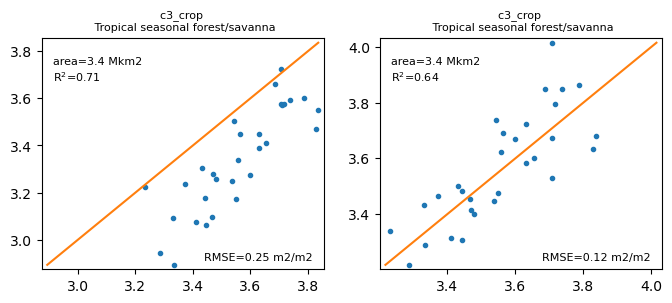

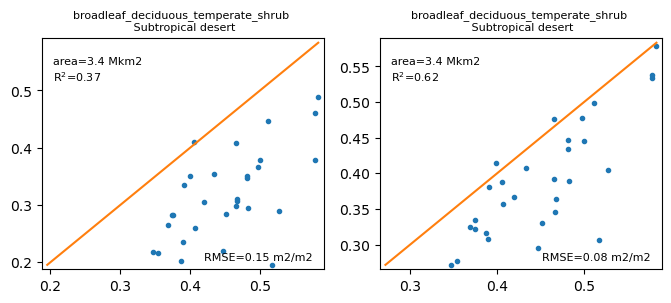

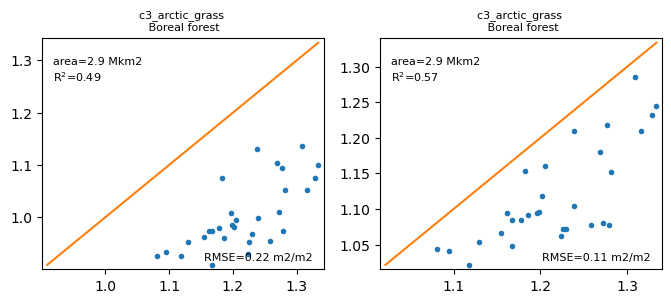

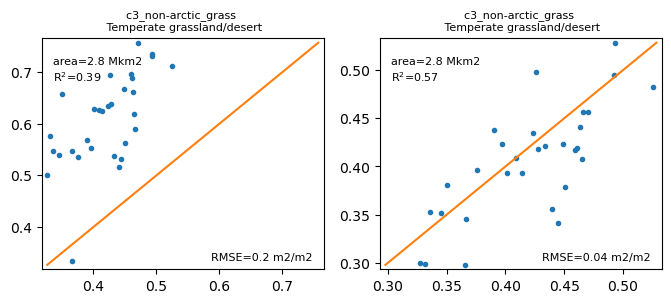

In [147]:
for pxb in pbs:
    plt.figure(figsize=[8,3])
    pft=int(pxb/10)  #PFT is the first one or two digits
    b=pxb-10*pft     #biome is the last digit
    
    a=np.round(area.sel(pxb=pxb).mean(dim='year')/1e6,1).values
    x=lais['lai_pxb_fg'].sel(pxb=pxb)
    ys=[lais['lai_pxb_sg'].sel(pxb=pxb),
        lais['lai_pxb_sg_newmap'].sel(pxb=pxb)]
    
    for i,y in enumerate(ys):
        plt.subplot(121+i)
        
        r2=np.round(np.corrcoef(x,y)[0,1]**2,2)
        rmse=np.round(np.sqrt(np.mean((x-y)**2).values),2)
        
        minn=np.min([x,y])
        maxx=np.max([x,y])
        delt=maxx-minn
        
        plt.plot(x,y,'.')
        plt.title(pftnames[pft]+' \n '+
                  str(whit.biome_name.sel(biome_id=b).values),fontsize=8);
        plt.xlim([minn-0.02*delt,maxx+0.02*delt])
        plt.ylim([minn-0.02*delt,maxx+0.02*delt])
        plt.plot([minn,maxx],[minn,maxx]);
        plt.text(minn+0.02*delt,minn+0.9*delt,'area='+str(a)+' Mkm2',fontsize=8)
        plt.text(minn+0.02*delt,minn+0.825*delt,'R$^2$='+str(r2),fontsize=8)
        plt.text(minn+0.98*delt,minn+0.02*delt,'RMSE='+str(rmse)+' m2/m2',fontsize=8,ha='right');




In [ ]:
la.isel(pft=ix).sum(dim='pft').plot.line('.')

### save off the sg mapping for pft data

In [4]:
# read in random sparsegrid file
f = '/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
sg = xr.open_dataset(f)

In [5]:
# read in random fullgrid file
d = '/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
f = 'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist.clm2.h1.2014-12.nc'
fg = xr.open_dataset(d+f)

In [6]:
# create the map from fg -> sg
ixp=sg.pfts1d_itype_veg>0
fgks=[]
k=np.arange(len(fg.pft))
for p,i,j in zip(sg.pfts1d_itype_veg[ixp],
                 sg.pfts1d_ixy[ixp],
                 sg.pfts1d_jxy[ixp]):
    ix=(fg.pfts1d_itype_veg==p)&(fg.pfts1d_ixy==i)&(fg.pfts1d_jxy==j)
    fgks.append(k[ix])
fgmap=np.zeros(len(sg.pft)).astype(int)
fgmap[ixp]=np.array(fgks).ravel()

In [14]:
tmp=xr.Dataset({'fgmap':xr.DataArray(fgmap,dims='pft')})

In [24]:
tmp.to_netcdf('fgmap.nc')